# Plot wind data from La Perouse DFO buoy 46206

About 50 km north of Barkley Canyon

In [1]:
# import modules

import xarray as xr
from datetime import datetime, timedelta
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import scipy.signal as sig
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [2]:
# import data

ds = xr.open_dataset(f'../../../Data/wind/wind.nc')
    
#print(ds)

In [3]:
# select data

year = 2013
t_stamp = f'{year}'
start_date = np.datetime64(f'{year}-01-01')
end_date = np.datetime64(f'{year+1}-01-01')

if year == 2013:
    dt_tot = ds.dt2013
    wdir_tot = ds.wdir2013
    wspd_tot = ds.wspd2013
elif year == 2014:
    dt_tot = ds.dt2014
    wdir_tot = ds.wdir2014
    wspd_tot = ds.wspd2014
elif year == 2017:
    dt_tot = ds.dt2017
    wdir_tot = ds.wdir2017
    wspd_tot = ds.wspd2017
elif year == 2018:
    dt_tot = ds.dt2018
    wdir_tot = ds.wdir2018
    wspd_tot = ds.wspd2018

In [5]:
# get data segments in lists

if year == 2013:
    dt0 = dt_tot[:]
    dt = [dt0]
    wspd0 = wspd_tot[:]
    wspd = [wspd0]
    wdir0 = wdir_tot[:]
    wdir = [wdir0]
    n_seg = 1
elif year == 2014:
    dt0 = dt_tot[:621]
    dt1 = dt_tot[621:]
    dt = [dt0,dt1]
    wspd0 = wspd_tot[:621]
    wspd1 = wspd_tot[621:]
    wspd = [wspd0,wspd1]
    wdir0 = wdir_tot[:621]
    wdir1 = wdir_tot[621:]
    wdir = [wdir0,wdir1]
    n_seg = 2
elif year == 2017:
    dt0 = dt_tot[:3974]
    dt1 = dt_tot[4100:5017]
    dt2 = dt_tot[5080:]
    dt = [dt0,dt1,dt2]
    wspd0 = wspd_tot[:3974]
    wspd1 = wspd_tot[4100:5017]
    wspd2 = wspd_tot[5080:]
    wspd = [wspd0,wspd1,wspd2]
    wdir0 = wdir_tot[:3974]
    wdir1 = wdir_tot[4100:5017]
    wdir2 = wdir_tot[5080:]
    wdir = [wdir0,wdir1,wdir2]
    n_seg = 3
elif year == 2018:
    dt0 = dt_tot[:]
    dt = [dt0]
    wspd0 = wspd_tot[:]
    wspd = [wspd0]
    wdir0 = wdir_tot[:]
    wdir = [wdir0]
    n_seg = 1

# interpolate over small data gaps

dt_int,dt0_int,dt_final = [],[],[]
for i in range(n_seg):
    dt_np_int = np.asarray(dt[i],dtype='int')
    tstart = dt_np_int[0]
    tend = dt_np_int[-1]
    dt_np_delta = dt_np_int[1] - dt_np_int[0]
    tt = np.arange(tstart,tend+dt_np_delta,dt_np_delta)     # new times as int
    ttdt = pd.to_datetime(tt)         # new times as datetime64
    dt_int.append(tt)           
    dt_final.append(np.asarray(ttdt))    
    dt0_int.append(dt_np_int)         # original times as int
    
wspd_int,wdir_int = [],[]
for i in range(n_seg):
    wspd_int.append(np.interp(dt_int[i],dt0_int[i],wspd[i]))
    wdir_int.append(np.interp(dt_int[i],dt0_int[i],wdir[i]))
    
dt = dt_final
wspd = wspd_int
wdir = wdir_int

## Wind speed and direction plots

In [ ]:
# smooth wind speeds

n = 5                              # reduce data
N = 701                             # smooth window
o = 2                               # filter order

wspd_s,wspd_n,dt_n = [],[],[]
for i in range(n_seg):
    wspd_st = sig.savgol_filter(wspd[i],N,o,mode='nearest')   # smoothed wind speed series
    wspd_nt = wspd_st[::n]                  # reduced wind speed series
    dt_t = dt[i]                     # segment time stamps
    dt_nt = dt_t[::n]                       # reduced time stamps, numpy.datetime64
    wspd_s.append(wspd_st)
    wspd_n.append(wspd_nt)
    dt_n.append(dt_nt)

In [ ]:
# smooth directions

N = 1501                             # smooth window
o = 2     

u_n,v_n = [],[]
for i in range(n_seg):
    deg_dir = 270 - wdir[i]            # wind direction, degrees
    rad_dir = np.radians(deg_dir)             # wind diretion, radians
    u = wspd[i]*np.cos(rad_dir)        # u wind velocity vector
    v = wspd[i]*np.sin(rad_dir)        # v wind velocity vector
    u_s = sig.savgol_filter(u,N,o,mode='nearest')
    v_s = sig.savgol_filter(v,N,o,mode='nearest')
    u_nt = u_s[::n] / np.sqrt(u_s[::n]**2 + v_s[::n]**2)
    v_nt = v_s[::n] / np.sqrt(u_s[::n]**2 + v_s[::n]**2)
    u_n.append(u_nt)
    v_n.append(v_nt)

In [ ]:
# make quiver grid

x,y = [],[]
for i in range(n_seg):
    if i == 0:
        count = len(dt_n[i])
        xt = np.arange(0,count,1)         # x coords
        yt = np.zeros(len(xt))              # y coords
        x.append(xt)
        y.append(yt)
    elif i > 0:
        count = len(dt_n[i])
        prev = len(dt_n[i-1])
        xt = np.arange(prev,prev+count,1)
        yt = np.zeros(len(xt))
        x.append(xt)
        y.append(yt)

In [ ]:
# plot smoothed data

fig, (ax0,ax1) = plt.subplots(2,1,figsize=(12,6),gridspec_kw={'height_ratios':[1,1]})
fig.subplots_adjust(hspace = 0)
fig.text(0.5, 0.9, f'Wind data (smoothed) - Station 46206 (Neah Bay) - {t_stamp}', ha='center', fontsize=14)
fig.text(0.08, 0.67, 'Direction [$\degree$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.08, 0.3, 'Magnitude [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.68, 'Magnitude [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.03, f'Months in {t_stamp} [mm]', ha='center',fontsize=14)

ccmap = 'inferno'
for i in range(n_seg):
    if year == 2013:
        ax0.quiver(x[i],y[i],u_n[i],v_n[i],wspd_n[i],angles='uv',scale_units='y',scale=1,width=0.0015,headwidth=5,cmap=ccmap)
        ax0.set_xlim(-25,x[0][-1])
        ax1.plot(dt_n[i], wspd_n[i], color='black')
    elif year == 2014:
        if i == 1:
            ax0.quiver((x[i]*0.75)+324,y[i],u_n[i],v_n[i],wspd_n[i],angles='uv',scale_units='y',scale=1,width=0.0015,headwidth=5,cmap=ccmap)
        else:
            ax0.quiver(x[i]*0.75,y[i],u_n[i],v_n[i],wspd_n[i],angles='uv',scale_units='y',scale=1,width=0.0015,headwidth=5,cmap=ccmap)
        ax0.set_xlim(x[0][0],x[1][-1])
        ax1.plot(dt_n[i], wspd_n[i], color='black')
    elif year == 2017:
        if i == 1:
            ax0.quiver((x[i]*0.22)+150,y[i],u_n[i],v_n[i],wspd_n[i],angles='uv',scale_units='y',scale=1,width=0.0015,headwidth=5,cmap=ccmap)
        elif i == 2:
            ax0.quiver((x[i]*0.27)+328,y[i],u_n[i],v_n[i],wspd_n[i],angles='uv',scale_units='y',scale=1,width=0.0015,headwidth=5,cmap=ccmap)
        else:
            ax0.quiver(x[i]*0.5,y[i],u_n[i],v_n[i],wspd_n[i],angles='uv',scale_units='y',scale=1,width=0.0015,headwidth=5,cmap=ccmap)
        ax0.set_xlim(x[0][0],x[2][-1])
        ax1.plot(dt_n[i], wspd_n[i], color='black')
    elif year == 2018:
        ax0.quiver(x[i]*0.55,y[i],u_n[i],v_n[i],wspd_n[i],angles='uv',scale_units='y',scale=1,width=0.0015,headwidth=5,cmap=ccmap)
        ax0.set_xlim(x[0][0],x[0][-1])
        ax1.plot(dt_n[i], wspd_n[i], color='black')
    
cbaxes = fig.add_axes([0.905,0.495,0.01,0.385])
norm = colors.Normalize()
norm.autoscale(wspd_n[0])
cm = matplotlib.cm.inferno
sm = matplotlib.cm.ScalarMappable(cmap=cm,norm=norm)
sm.set_array([])
cbar0 = plt.colorbar(sm,cax=cbaxes, fraction=0.05, pad=0.01, aspect=15)
cbar0.ax.tick_params(labelsize=14)

ax0.set_ylim(-1.1,1.1)
ax0.tick_params(axis='both',left=None,labelleft=None,bottom=None,labelbottom=None)
date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./wind_{t_stamp}.pdf',format='pdf')

## CW wind spectra

In [ ]:
# spectra data adjustments & Welch parameters

time_total = 0
for i in range(n_seg):
    time_total += len(dt[i])
print('Total time length:',time_total)

# set Welch parameters for PSD

fs = 1/3600                   # 4 samples per HOUR, 1.11e-3 per SECOND
win = 'hann'                  # optimal window for averaging
nps = 256                     # find optimal window for nperseg (1024 ~10 days)
overlap = 0.9 * nps           # 50% overlap, default   

# remove short segments

t_short = []
for i in range(n_seg):
    if len(dt[i]) < nps:
        t_short.append(i)
for i in sorted(t_short, reverse=True):
    del dt[i]
n_seg = n_seg - len(t_short)

time_total = 0
for i in range(n_seg):
    time_total += len(dt[i])
print(len(t_short),'segment(s) too short, new total time length:',time_total)

In [6]:
# convert wind-speed and direction to u and v vectors

u,v = [],[]
for i in range(n_seg):
    deg_dir = 270 - wdir[i]            # wind direction, degrees
    rad_dir = np.radians(deg_dir)             # wind diretion, radians
    u_temp = wspd[i]*np.cos(rad_dir)        # u wind velocity vector
    v_temp = wspd[i]*np.sin(rad_dir)        # v wind velocity vector
    u.append(u_temp)
    v.append(v_temp)

In [ ]:
# remove mean

um,vm = [],[]
for i in range(n_seg):
    um_temp = np.copy(u[i]) - np.nanmean(u[i])
    vm_temp = np.copy(v[i]) - np.nanmean(v[i])
    um.append(um_temp)     # list[segment][depth][time]
    vm.append(vm_temp)     # 0 is upper depth index

In [ ]:
def spectrocross(u,v,fs,window,nperseg,noverlap,nfft,detrend,return_onesided,scaling,axis,mode):
    freqs, time, Sxy = sig._spectral_helper(u, v, fs, window, nperseg,
                                            noverlap, nfft, detrend,
                                            return_onesided, scaling, axis,
                                            mode='psd')        # get this from scipy spectral.py in pkgs (add name to import list)
    return freqs, time, Sxy

In [ ]:
# get rotary spectrograms

Scw,Sccw,f,ft = [],[],[],[]
for i in range(n_seg):
    u_f, u_t, u_Sxx = sig.spectrogram(um[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
    v_f, v_t, v_Sxx = sig.spectrogram(vm[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
    uv_f,uv_t,uv_Cxy = spectrocross(vm[i],um[i],fs=fs,window=win,nperseg=nps,noverlap=overlap,nfft=None,detrend='constant',
                    return_onesided=True,scaling='density',axis=-1,mode='psd')     # cross spectrogram
    Sxyuv = uv_Cxy.imag                             # quadrature spectra is imag part of cross spectra
    Scw_temp = ((u_Sxx + v_Sxx) - (2*Sxyuv)) / 2         # rotatory components
    Sccw_temp = ((u_Sxx + v_Sxx) + (2*Sxyuv)) / 2 
    
    # convert spectro_t to datetime for x-axis on plots for PSD
    spectro_t4 = u_t*fs
    spectro_time_len = len(spectro_t4)
    spectro_time_axis = np.zeros([spectro_time_len],dtype='datetime64[s]')
    for k in range(spectro_time_len):
        j = int(spectro_t4[k])
        spectro_time_axis[k] = dt[i][j]
        
    Scw.append(Scw_temp)
    Sccw.append(Sccw_temp)
    f.append(u_f)
    ft.append(spectro_time_axis)

In [ ]:
# plot spectrogram

fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1)
fig.text(0.5, 0.93, f'Wind spectrograms - {t_stamp}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.93, 0.5, 'S$_{xx}$ [(m/s)$^2$/Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0.03, f'Time [months]', ha='center',fontsize=14)
    
fig.text(0.5, 0.886, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.482, 'CCW', ha='center', fontsize=14)
fig.text(0.13, 0.205, 'f', ha='center', fontsize=18, color='white',zorder=4)
fig.text(0.13, 0.605, 'f', ha='center', fontsize=18, color='white',zorder=4)
vmin = 1e4
vmax = 1e6
ax0.axhline(1.74e-5,color='white',ls='--',lw=1)
ax1.axhline(1.74e-5,color='white',ls='--',lw=1)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ft[i], f[0], Scw[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ft[i], f[0], Sccw[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')   
cbar0.ax.tick_params(labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')   
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

ax1.set_yscale('log')
ax1.set_ylim(1e-5,1e-4)
date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax1.tick_params(labelsize=14)
ax0.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./wind_spectro_{t_stamp}.pdf',format='pdf')

In [ ]:
# integrate at each time step

Scw_int, Sccw_int = [],[]

for i in range(n_seg):
    Scw_int_temp = []
    Scw_np = np.copy(Scw[i])
    Sccw_int_temp = []
    Sccw_np = np.copy(Sccw[i])
    for j in range(len(Scw_np[0,:])):      
        Scw_int_temp.append(np.trapz(y=Scw_np[14:19,j],x=f[0][14:19]))
    for j in range(len(Sccw_np[0,:])):      
        Sccw_int_temp.append(np.trapz(y=Sccw_np[14:19,j],x=f[0][14:19]))
    Scw_int.append(np.asarray(Scw_int_temp))
    Sccw_int.append(np.asarray(Sccw_int_temp))

In [ ]:
# plot band-passed integrated rotary data

fig, ax0 = plt.subplots(1,1,figsize=(12,5))
fig.text(0.5, 0.91, f'Integrated near-inertial wind power - Station 46206 (Neah Bay) - {t_stamp}', ha='center', fontsize=14)

for i in range(n_seg):
    if i == 0:
        ax0.plot(ft[i],Scw_int[i],color='tab:blue',label='CW')
        ax0.plot(ft[i],Sccw_int[i],color='tab:orange',label='CCW')
        ax0.plot(ft[i],Scw_int[i][:]+Sccw_int[i][:],color='grey',ls='--',lw=1,label='Total')
    elif i > 0:
        ax0.plot(ft[i],Scw_int[i],color='tab:blue')
        ax0.plot(ft[i],Sccw_int[i],color='tab:orange')
        ax0.plot(ft[i],Scw_int[i][:]+Sccw_int[i][:],color='grey',ls='--',lw=1)
        
ax0.set_xlabel(f'Months in {t_stamp} [mm]',fontsize=14)
fig.text(0.07, 0.5, f'Power [(m/s)$^2$]', va='center', rotation='vertical', fontsize=14)
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)

plt.legend(fontsize=14)
plt.show()

plt.savefig(fname=f'./wind_power_{t_stamp}.pdf',format='pdf')

## Slab model
Outlined by Alford (2001), D'Asaro (1985), and Garratt (1977).

In [7]:
# get wind vector
U = []
for i in range(n_seg):
    unp_temp = np.asarray(u[i][:])
    vnp_temp = np.asarray(v[i][:])
    U.append(unp_temp + (vnp_temp*1j))   # vector wind velocities   

In [8]:
# get wind stress (Garratt 1977)
tau = []
for i in range(n_seg):
    Cd = 0.51 * (U[i] ** 0.46) / (1e3)            # Garratt 1977, drag coefficient
    tau.append(Cd * (U[i]**2))                    # Garratt 1977, wind stress [N/m^2], approximate density of air as 1

In [9]:
# get inertial oscillations in mixed layer (D'Asaro 1985 and Alford 2001)

cor = 1.74e-5         # local Coriolis parameter
r = 1.45e-6           # about ~8 days for north pacific, average over year (Park et al., 2009)
roh = 1024            # avg density of mixed layer seawater from N2 calculations (similar for either season)
omega = r + (cor*1j)  # damping and Coriolis relation

T = []
for i in range(n_seg):
    T.append(tau[i] / roh)         # wind stress for seawater density

In [10]:
# get time steps

st = 3600                      # hourly data

nt,t = [],[]
for i in range(n_seg):
    nt_temp = len(dt[i])                          # number of data points
    t_temp = np.linspace(0,nt_temp-1,nt_temp,dtype='int')     # time points
    nt.append(nt_temp)
    t.append(t_temp)

In [11]:
# get seasonal mixed layer depth (Li 2004, Line P station 3)

# months_np = np.array([0,360,1083,1805,2527,3249,3971,4693,5415,6137,6859,7581,8303,8665])
# MLD_months = [50,52,60,49,30,21,19,19,18,22,26,43,48,50]    # monthly mixed layer depth [m], first/last values are estimated end points
# H = np.interp(t[0],months_np,MLD_months)                       # MLD at each time step [m]
# ### t above will cause issues now that this is a segmented process###

# # save to .nc file

# ds_out = xr.Dataset( 
#     data_vars=dict(
#         H=(['time'], -H),        # mixed-layer depth [m]
#     ),
#     coords=dict(
#         time=np.asarray(dt[0]),               # np.datetime64    
#     ),
#     attrs=dict(
#         description=f'Seasonal mixed-layer depth for a full year, Line P station 3.',
#         units=['m, numpy.datetime64'],
#     ),
# ) 
# ds_out.to_netcdf(f'../../../Data/wind/mld.nc')

In [12]:
# plot seasonal mixed layer depth

# fig,ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(dt[0],-H)
# ax.set_title('Time-mean mixed-layer depth - Line P Station 3 - 1956-2001',fontsize=14)
# ax.set_ylabel('Depth [m]',fontsize=14)
# ax.set_xlabel('Time [months]',fontsize=14)
# date_form = pldates.DateFormatter("%m")
# ax.xaxis.set_major_formatter(date_form)
# ax.set_xlim(start_date,end_date)
# ax.tick_params(labelsize=14)
# plt.show()

# plt.savefig(fname=f'./mld.pdf',format='pdf')

In [13]:
# get mixed-layer depth data

dsH = xr.open_dataset(f'../../../Data/wind/mld.nc')
Hm = -dsH.H.values
Htm = dsH.time.values

# get data segments in lists (H, Ht)

if year == 2013:
    Hm0 = Hm[:]
    H = [Hm0]
    Htm0 = Htm[:]
    Ht = [Htm0]
    n_seg = 1
elif year == 2014:
    Hm0 = Hm[:621]
    Hm1 = Hm[2811:]
    H = [Hm0,Hm1]
    Htm0 = Htm[:621]
    Htm1 = Htm[2811:]
    Ht = [Htm0,Htm1]
    n_seg = 2
elif year == 2017:
    Hm0 = Hm[:2389]
    Hm1 = Hm[4987:5904]
    Hm2 = Hm[7335:]
    H = [Hm0,Hm1,Hm2]
    Htm0 = Htm[:2389]
    Htm1 = Htm[4987:5904]
    Htm2 = Htm[7335:]
    Ht = [Htm0,Htm1,Htm2]
    n_seg = 3
elif year == 2018:
    Hm0 = Hm[:4799]
    H = [Hm0]
    Htm0 = Htm[:4799]
    Ht = [Htm0]
    n_seg = 1

In [14]:
# get mixed layer velocities and flux

Zi = []   # complex mixed layer velocities (resonates around f)
Fi = []   # input flux from wind

for i in range(n_seg):
    Zi_temp = [0]
    Fi_temp = [0]
    for j in np.arange(1,nt[i],1):
        Tt = (T[i][j]-T[i][j-1]) / st
        Zi2 = (Zi_temp[j-1] * np.exp(-omega*st)) - ( (Tt / (H[i][j]*(omega**2))) * (1 - np.exp(-omega*st)) )
        Zi_temp.append(Zi2)
        Fi2 = np.real( (np.conj(Tt) / (st*(abs(omega)**2)*H[i][j])) * 
                       ((((Zi_temp[j-1] + (Tt / ((omega**2) * H[i][j])))) * (np.exp(-omega*st) - 1)) + ((Tt/(omega*H[i][j]))*st) ) )
        Fi_temp.append(Fi2)
    Zi.append(Zi_temp)
    Fi.append(Fi_temp)

<IPython.core.display.Javascript object>


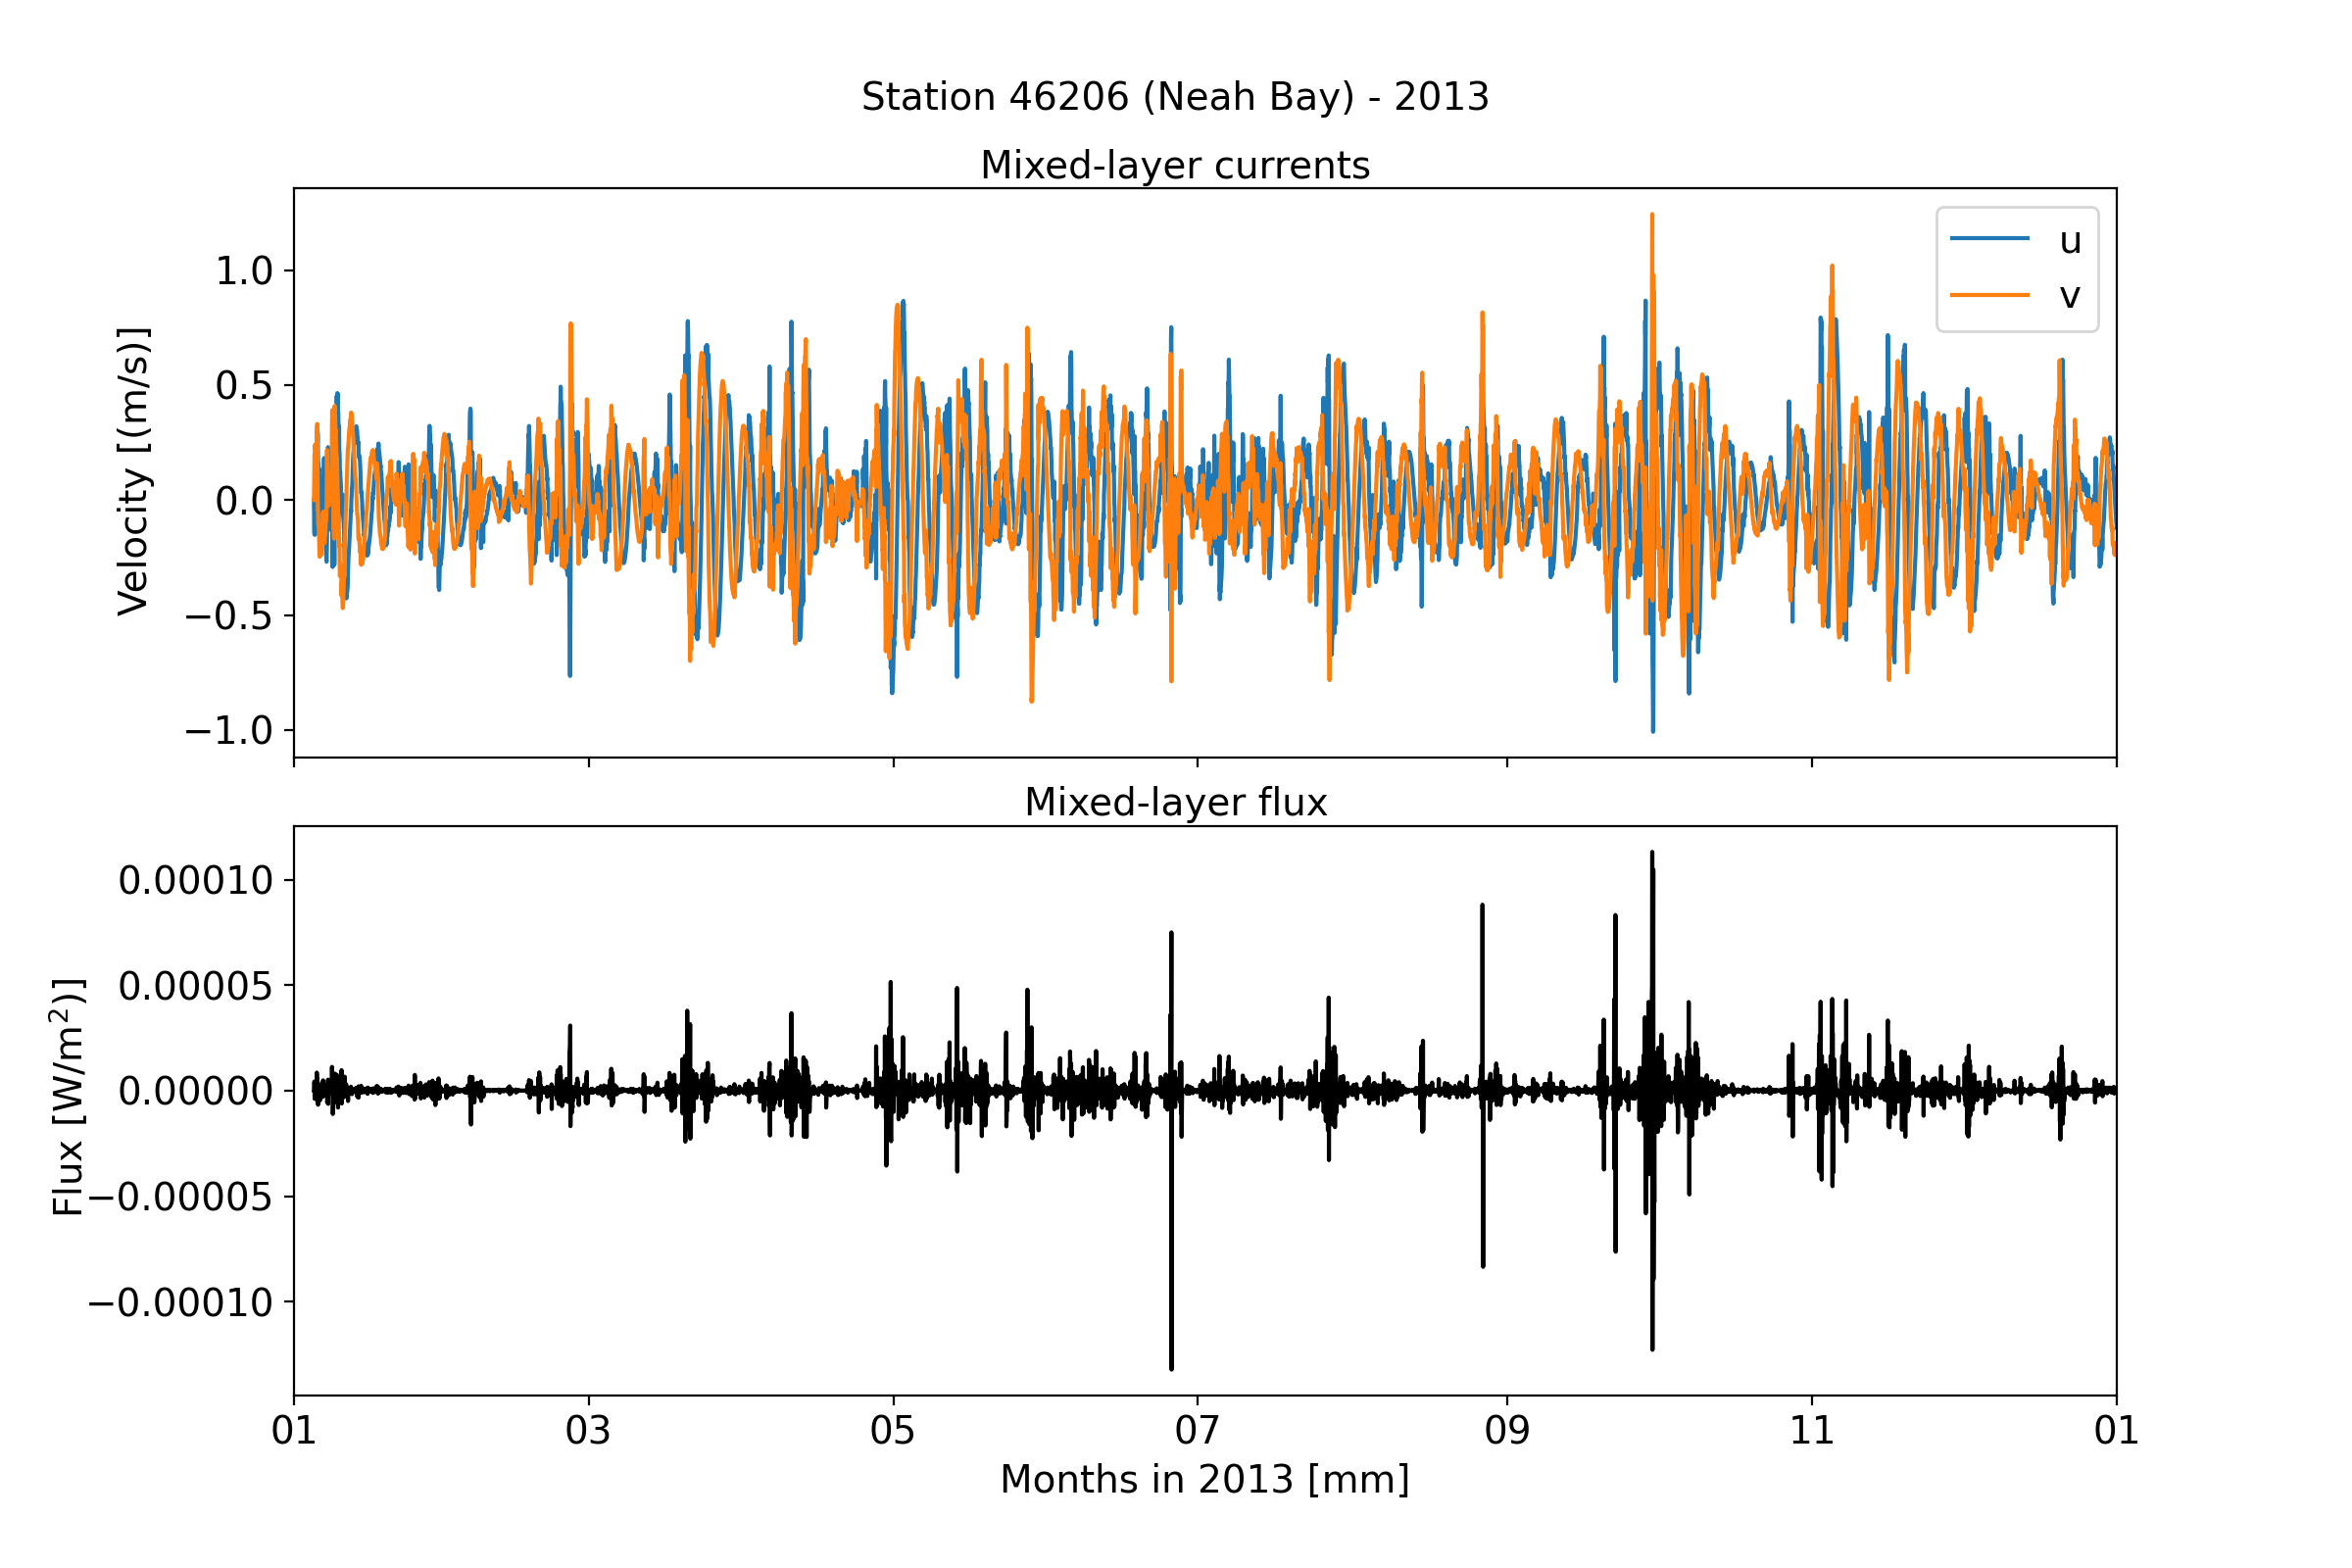

In [15]:
# plot ML current data

fig, (ax0,ax1) = plt.subplots(2,1,figsize=(12,8),sharex=True)
fig.subplots_adjust(hspace=0.12)
fig.text(0.5, 0.93, f'Station 46206 (Neah Bay) - {t_stamp}', ha='center', fontsize=14)
fig.text(0.5, 0.886, f'Mixed-layer currents', ha='center', fontsize=14)
fig.text(0.5, 0.48, f'Mixed-layer flux', ha='center', fontsize=14)
fig.text(0.05, 0.7, f'Velocity [(m/s)]', va='center', rotation='vertical', fontsize=14)
fig.text(0.02, 0.3, f'Flux [W/m$^2$)]', va='center', rotation='vertical', fontsize=14)
ax1.set_xlabel(f'Months in {t_stamp} [mm]',fontsize=14)

for i in range(n_seg):
    if i == 0:
        ax0.plot(dt[i],np.real(Zi[i]),color='tab:blue',label='u')
        ax0.plot(dt[i],np.imag(Zi[i]),color='tab:orange',label='v')
        ax1.plot(dt[i],Fi[i],color='black')
    elif i > 0:
        ax0.plot(dt[i],np.real(Zi[i]),color='tab:blue')
        ax0.plot(dt[i],np.imag(Zi[i]),color='tab:orange')
        ax1.plot(dt[i],Fi[i],color='black')
        
        
date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

ax0.legend(fontsize=14)
plt.show()

plt.savefig(fname=f'./inertial_currents_{t_stamp}.pdf',format='pdf')

In [16]:
# save to .nc file

for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            Zu=(['time'], np.real(Zi[i])),        # mixed-layer currents
            Zv=(['time'], np.imag(Zi[i])),
            H=(['time'], H[i]),
        ),
        coords=dict(
            time=dt[i],                       # np.datetime64 
        ),
        attrs=dict(
            description=f'Mixed-layer wind induced currents, Line P station 3, {t_stamp}. Segment {i} of {n_seg}.',
            units=['(m/s), numpy.datetime64'],
            n_seg=n_seg,
        ),
    ) 
    ds_out.to_netcdf(f'../../../Data/wind/ml_currents_{t_stamp}_{i}.nc')

In [17]:
# spectral parameters

fs = 1/3600                   # one sample per hour in Hz
win = 'hann'                  # optimal window for averaging
nps = 256                     # find optimal window for nperseg (1024 ~10 days)
overlap = 0.9 * nps           # 50% overlap, default 

In [18]:
# u and v components

u,v = [],[]
for i in range(n_seg):
    u.append(np.real(Zi[i]))
    v.append(np.imag(Zi[i]))

In [19]:
# remove mean

um,vm = [],[]
for i in range(n_seg):
    um_temp = np.copy(u[i]) - np.nanmean(u[i])
    vm_temp = np.copy(v[i]) - np.nanmean(v[i])
    um.append(um_temp)     # list[segment][depth][time]
    vm.append(vm_temp)     # 0 is upper depth index

In [20]:
def spectrocross(u,v,fs,window,nperseg,noverlap,nfft,detrend,return_onesided,scaling,axis,mode):
    freqs, time, Sxy = sig._spectral_helper(u, v, fs, window, nperseg,
                                            noverlap, nfft, detrend,
                                            return_onesided, scaling, axis,
                                            mode='psd')        # get this from scipy spectral.py in pkgs (add name to import list)
    return freqs, time, Sxy

In [21]:
# get rotary spectrograms

Scw,Sccw,f,ft = [],[],[],[]
for i in range(n_seg):
    u_f, u_t, u_Sxx = sig.spectrogram(um[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
    v_f, v_t, v_Sxx = sig.spectrogram(vm[i], fs=fs, window=win, \
                                                            nperseg = nps, noverlap = overlap, return_onesided=True)
    uv_f,uv_t,uv_Cxy = spectrocross(vm[i],um[i],fs=fs,window=win,nperseg=nps,noverlap=overlap,nfft=None,detrend='constant',
                    return_onesided=True,scaling='density',axis=-1,mode='psd')     # cross spectrogram
    Sxyuv = uv_Cxy.imag                                  # quadrature spectra is imag part of cross spectra
    Scw_temp = ((u_Sxx + v_Sxx) - (2*Sxyuv)) / 2         # rotatory components
    Sccw_temp = ((u_Sxx + v_Sxx) + (2*Sxyuv)) / 2 
    
    # convert spectro_t to datetime for x-axis on plots for PSD
    spectro_t4 = u_t*fs
    spectro_time_len = len(spectro_t4)
    spectro_time_axis = np.zeros([spectro_time_len],dtype='datetime64[s]')
    for k in range(spectro_time_len):
        j = int(spectro_t4[k])
        spectro_time_axis[k] = dt[i][j]
        
    Scw.append(Scw_temp)
    Sccw.append(Sccw_temp)
    f.append(u_f)
    ft.append(spectro_time_axis)

<IPython.core.display.Javascript object>


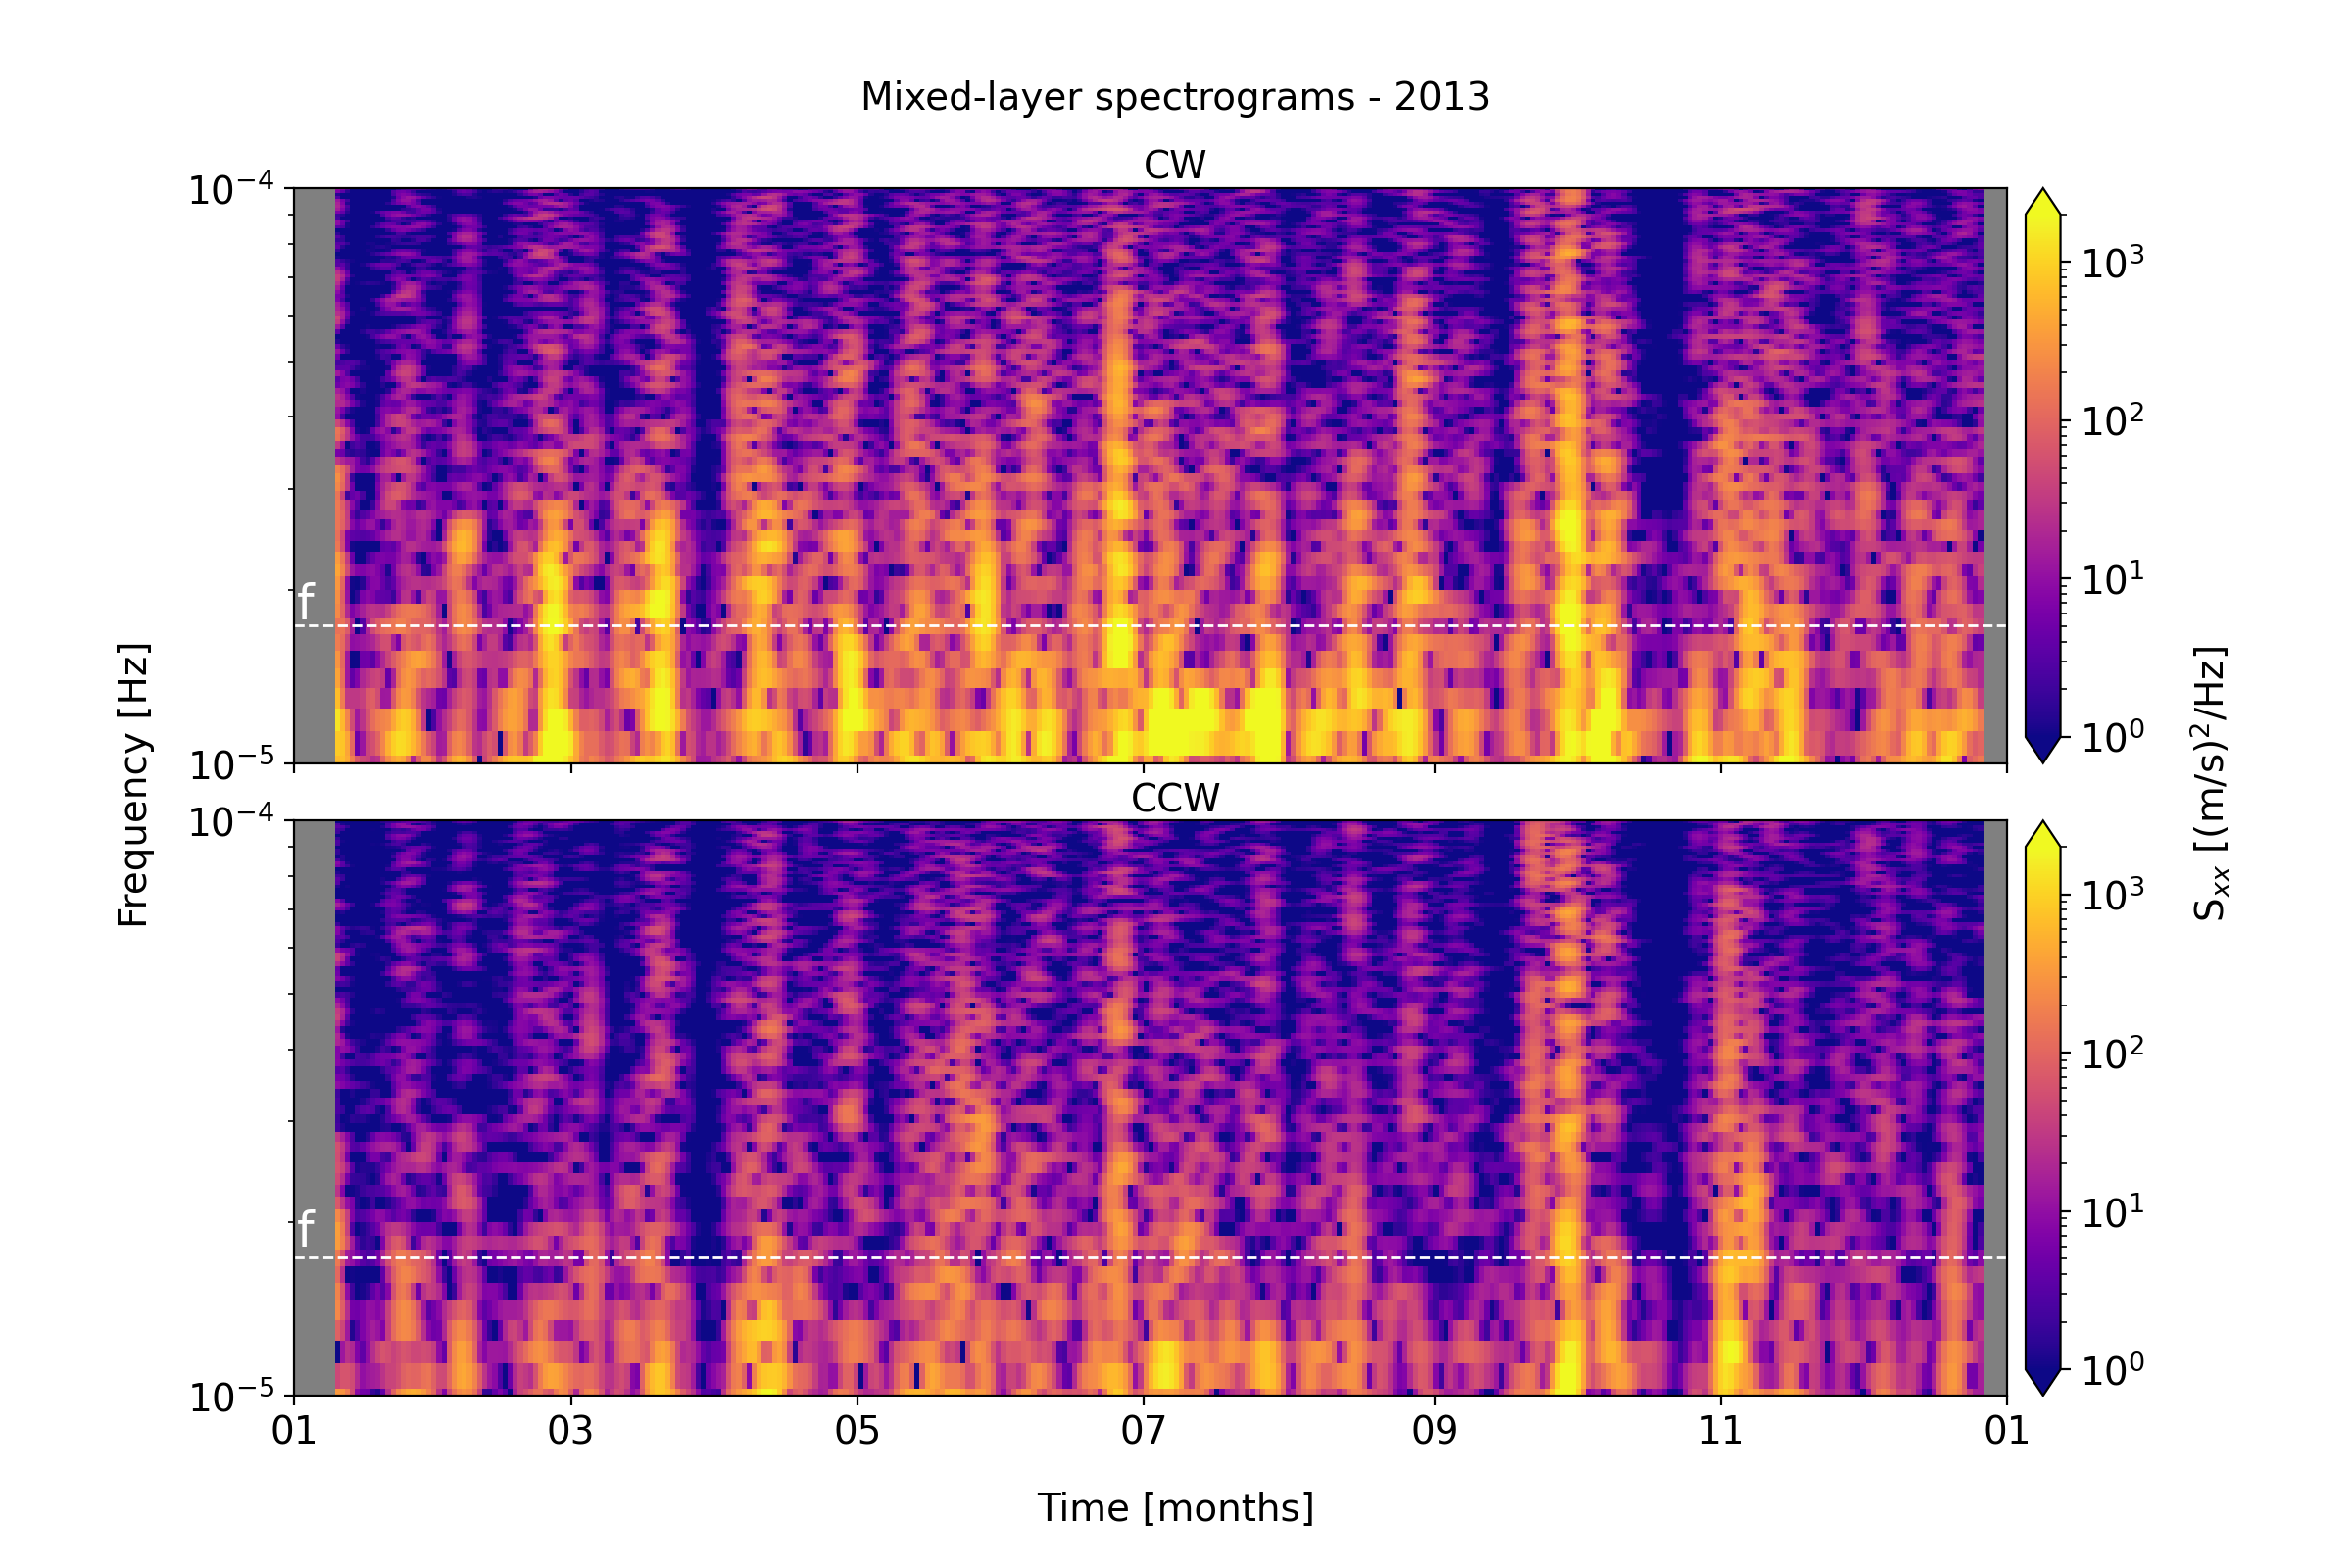

In [22]:
# plot spectrogram

fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1)
fig.text(0.5, 0.93, f'Mixed-layer spectrograms - {t_stamp}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.93, 0.5, 'S$_{xx}$ [(m/s)$^2$/Hz]', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0.03, f'Time [months]', ha='center',fontsize=14)
    
fig.text(0.5, 0.886, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.482, 'CCW', ha='center', fontsize=14)
fig.text(0.13, 0.205, 'f', ha='center', fontsize=18, color='white',zorder=4)
fig.text(0.13, 0.605, 'f', ha='center', fontsize=18, color='white',zorder=4)
vmin = 1e0
vmax = 2e3
ax0.axhline(1.74e-5,color='white',ls='--',lw=1)
ax1.axhline(1.74e-5,color='white',ls='--',lw=1)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ft[i], f[i], Scw[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ft[i], f[i], Sccw[i], rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')   
cbar0.ax.tick_params(labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')   
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

ax1.set_yscale('log')
ax1.set_ylim(1e-5,1e-4)
date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax1.tick_params(labelsize=14)
ax0.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./slab_spectro_{t_stamp}.pdf',format='pdf')

In [23]:
# integrate at each time step

Scw_int, Sccw_int = [],[]

for i in range(n_seg):
    Scw_int_temp = []
    Scw_np = np.copy(Scw[i])
    Sccw_int_temp = []
    Sccw_np = np.copy(Sccw[i])
    for j in range(len(Scw_np[0,:])):      
        Scw_int_temp.append(np.trapz(y=Scw_np[14:19,j],x=f[i][14:19]))
    for j in range(len(Sccw_np[0,:])):      
        Sccw_int_temp.append(np.trapz(y=Sccw_np[14:19,j],x=f[i][14:19]))
    Scw_int.append(np.asarray(Scw_int_temp))
    Sccw_int.append(np.asarray(Sccw_int_temp))

<IPython.core.display.Javascript object>


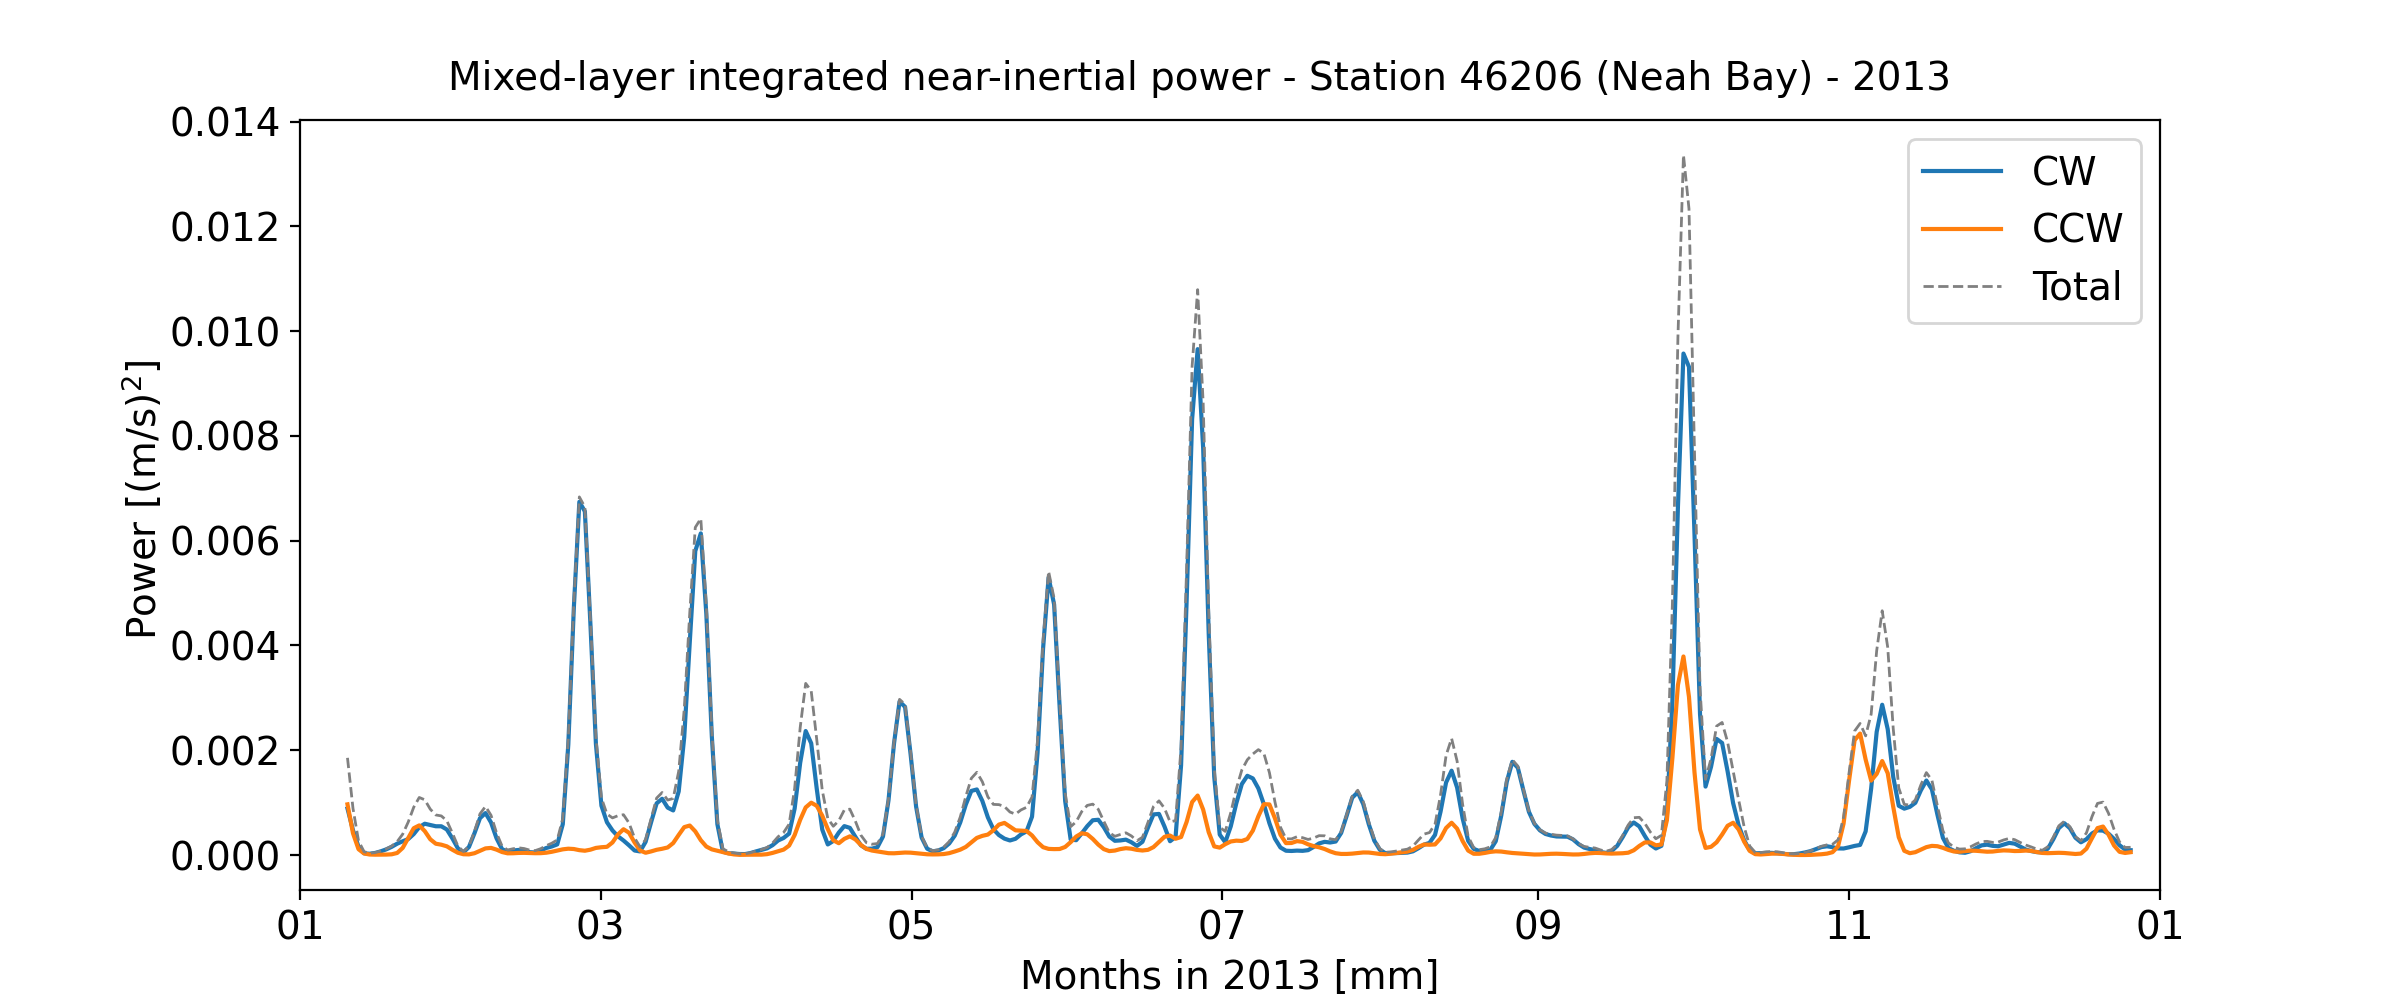

In [24]:
# plot band-passed integrated rotary data

fig, ax0 = plt.subplots(1,1,figsize=(12,5))
fig.text(0.5, 0.91, f'Mixed-layer integrated near-inertial power - Station 46206 (Neah Bay) - {t_stamp}', ha='center', fontsize=14)

for i in range(n_seg):
    if i == 0:
        ax0.plot(ft[i],Scw_int[i],color='tab:blue',label='CW')
        ax0.plot(ft[i],Sccw_int[i],color='tab:orange',label='CCW')
        ax0.plot(ft[i],Scw_int[i][:]+Sccw_int[i][:],color='grey',ls='--',lw=1,label='Total')
    elif i > 0:
        ax0.plot(ft[i],Scw_int[i],color='tab:blue')
        ax0.plot(ft[i],Sccw_int[i],color='tab:orange')
        ax0.plot(ft[i],Scw_int[i][:]+Sccw_int[i][:],color='grey',ls='--',lw=1)
        
ax0.set_xlabel(f'Months in {t_stamp} [mm]',fontsize=14)
fig.text(0.05, 0.5, f'Power [(m/s)$^2$]', va='center', rotation='vertical', fontsize=14)
date_form = pldates.DateFormatter("%m")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)

plt.legend(fontsize=14)
plt.show()

plt.savefig(fname=f'./slab_power_{t_stamp}.pdf',format='pdf')

In [25]:
# save to .nc file

for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            cw=(['time'], Scw_int[i]),        # integrated near-inertial power [(m/s)^2]
        ),
        coords=dict(
            time=ft[i],                       # np.datetime64    
        ),
        attrs=dict(
            description=f'Integrated near-inertial slab power, Line P station 3, {t_stamp}. Segment {i} of {n_seg}.',
            units=['(m/s)^2, numpy.datetime64'],
            n_seg=n_seg,
        ),
    ) 
    ds_out.to_netcdf(f'../../../Data/wind/cw_inertial_{t_stamp}_{i}.nc')